## Loading a model from mlflow
Loading a model from the mlflow's backend for our purposes (predicting on new data) can be done at least in three ways:
* load the best run available (according to a rule, i.e. a metric)
* load a registered version of the model (this needs the model to be registered)
* load a model from a given environment (this needs the model to be registered AND transitioned to a different stage)

In [1]:
import numpy as np 
import pandas as pd 
import mlflow
import mlflow.xgboost
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient

import warnings
warnings.filterwarnings('ignore')

### Loading given the **stage**
needs the model to be registered **AND** in a specific environment

In [2]:
TRACKING_URI = "http://127.0.0.1:5000/"

REG_MODEL_NAME = "enefit_xgboost"

In [3]:
client = MlflowClient(tracking_uri=TRACKING_URI)

In [4]:
model_metadata = client.get_latest_versions(name=REG_MODEL_NAME, stages=["Staging"])
model_metadata

[<ModelVersion: aliases=[], creation_timestamp=1703780670169, current_stage='Staging', description='', last_updated_timestamp=1703780759271, name='enefit_xgboost', run_id='a2ca85cf93ab48a29c6cce33ffb0cb50', run_link='', source='mlflow-artifacts:/927635481385254895/a2ca85cf93ab48a29c6cce33ffb0cb50/artifacts/xgboost_model', status='READY', status_message='', tags={}, user_id='', version='1'>]

In [5]:
version = model_metadata[0].version
version

'1'

In [6]:
run_id = model_metadata[0].run_id
run_id

'a2ca85cf93ab48a29c6cce33ffb0cb50'

In [7]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
artifact_path = "xgboost_model"
model = mlflow.xgboost.load_model(model_uri=f"runs:/{run_id}/{artifact_path}")

In [8]:
# model signature
model_info = mlflow.models.get_model_info(f"runs:/{run_id}/{artifact_path}")
model_info.signature_dict

{'inputs': '[{"type": "long", "name": "is_business"}, {"type": "long", "name": "is_consumption"}, {"type": "integer", "name": "year"}, {"type": "long", "name": "datediff_in_days"}, {"type": "integer", "name": "hour"}, {"type": "double", "name": "hour_cosine"}, {"type": "integer", "name": "dayofweek"}, {"type": "double", "name": "dayofweek_cosine"}, {"type": "integer", "name": "week"}, {"type": "double", "name": "week_cosine"}, {"type": "integer", "name": "month"}, {"type": "double", "name": "month_sine"}, {"type": "double", "name": "target_1_days_ago"}, {"type": "double", "name": "target_7_days_ago"}, {"type": "double", "name": "installed_capacity"}, {"type": "double", "name": "lowest_price_per_mwh"}, {"type": "double", "name": "temperature_mean_f"}, {"type": "double", "name": "temperature_max_f"}, {"type": "double", "name": "dewpoint_min_f"}, {"type": "double", "name": "dewpoint_mean_f"}, {"type": "double", "name": "dewpoint_max_f"}, {"type": "double", "name": "dewpoint_std_f"}, {"typ

In [9]:
import ast
ast.literal_eval(model_info.signature_dict["inputs"])

[{'type': 'long', 'name': 'is_business'},
 {'type': 'long', 'name': 'is_consumption'},
 {'type': 'integer', 'name': 'year'},
 {'type': 'long', 'name': 'datediff_in_days'},
 {'type': 'integer', 'name': 'hour'},
 {'type': 'double', 'name': 'hour_cosine'},
 {'type': 'integer', 'name': 'dayofweek'},
 {'type': 'double', 'name': 'dayofweek_cosine'},
 {'type': 'integer', 'name': 'week'},
 {'type': 'double', 'name': 'week_cosine'},
 {'type': 'integer', 'name': 'month'},
 {'type': 'double', 'name': 'month_sine'},
 {'type': 'double', 'name': 'target_1_days_ago'},
 {'type': 'double', 'name': 'target_7_days_ago'},
 {'type': 'double', 'name': 'installed_capacity'},
 {'type': 'double', 'name': 'lowest_price_per_mwh'},
 {'type': 'double', 'name': 'temperature_mean_f'},
 {'type': 'double', 'name': 'temperature_max_f'},
 {'type': 'double', 'name': 'dewpoint_min_f'},
 {'type': 'double', 'name': 'dewpoint_mean_f'},
 {'type': 'double', 'name': 'dewpoint_max_f'},
 {'type': 'double', 'name': 'dewpoint_std_f

In [10]:
inputs = ast.literal_eval(model_info.signature_dict["inputs"])
# features to use for prediction
input_columns = [d['name'] for d in inputs]
input_columns

['is_business',
 'is_consumption',
 'year',
 'datediff_in_days',
 'hour',
 'hour_cosine',
 'dayofweek',
 'dayofweek_cosine',
 'week',
 'week_cosine',
 'month',
 'month_sine',
 'target_1_days_ago',
 'target_7_days_ago',
 'installed_capacity',
 'lowest_price_per_mwh',
 'temperature_mean_f',
 'temperature_max_f',
 'dewpoint_min_f',
 'dewpoint_mean_f',
 'dewpoint_max_f',
 'dewpoint_std_f',
 'cloudcover_high_min_f',
 'cloudcover_high_max_f',
 'cloudcover_low_max_f',
 'cloudcover_mid_min_f',
 'cloudcover_mid_mean_f',
 'cloudcover_mid_max_f',
 'cloudcover_total_min_f',
 'cloudcover_total_mean_f',
 'cloudcover_total_max_f',
 '10_metre_u_wind_component_max_f',
 '10_metre_u_wind_component_std_f',
 '10_metre_v_wind_component_mean_f',
 'direct_solar_radiation_mean_f',
 'surface_solar_radiation_downwards_min_f',
 'surface_solar_radiation_downwards_mean_f',
 'surface_solar_radiation_downwards_max_f',
 'surface_solar_radiation_downwards_std_f',
 'snowfall_min_f',
 'snowfall_mean_f',
 'snowfall_std_f'

In [11]:
len(input_columns)

59

### Loading the **best experiment run**
even if the model is not registered

In [12]:
experiment_name = "xgboost"
experiment = mlflow.search_experiments(filter_string=f"name='{experiment_name}'")
experiment

[<Experiment: artifact_location='mlflow-artifacts:/927635481385254895', creation_time=1702141853548, experiment_id='927635481385254895', last_update_time=1702141853548, lifecycle_stage='active', name='xgboost', tags={}>]

In [13]:
exp_id = experiment[0]._experiment_id
exp_id

'927635481385254895'

In [14]:
best_run = client.search_runs(
    experiment_ids=[exp_id],
    filter_string="",
    max_results=1,
    order_by=["metrics.MAE ASC"], # according to MAE
)[0]

best_run

<Run: data=<RunData: metrics={'MAE': 57.05648716686634,
 'MAPE': 423135273277556.7,
 'MASE': 0.12780456663038253,
 'MSE': 41161.008579856454,
 'RMSE': 201.46573537457948}, params={'alpha': '0.009465232755839163',
 'colsample_bylevel': '0.7064194229926998',
 'colsample_bynode': '0.7158440177982559',
 'colsample_bytree': '0.9229606824866499',
 'eta': '0.041159428141083886',
 'eval_metric': 'mae',
 'lambda': '1.2908697628355246',
 'max_depth': '12',
 'min_child_weight': '0.031507317401508694',
 'n_estimators': '122',
 'num_boost_round': '19',
 'num_leaves': '34',
 'subsample': '0.7769186287426424'}, tags={'alpha_distribution': 'FloatDistribution(high=0.3, log=True, low=0.001, '
                       'step=None)',
 'colsample_bylevel_distribution': 'FloatDistribution(high=1.0, log=True, '
                                   'low=0.5, step=None)',
 'colsample_bynode_distribution': 'FloatDistribution(high=1.0, log=True, '
                                  'low=0.5, step=None)',
 'colsample_b

In [15]:
best_run.info.run_id

'a2ca85cf93ab48a29c6cce33ffb0cb50'

In [16]:
best_run.info.artifact_uri

'mlflow-artifacts:/927635481385254895/a2ca85cf93ab48a29c6cce33ffb0cb50/artifacts'

In [17]:
model = mlflow.xgboost.load_model(model_uri=f"runs:/{best_run.info.run_id}/{artifact_path}")

In [18]:
# model signature
model_info = mlflow.models.get_model_info(f"runs:/{best_run.info.run_id}/{artifact_path}")
model_info.signature_dict

{'inputs': '[{"type": "long", "name": "is_business"}, {"type": "long", "name": "is_consumption"}, {"type": "integer", "name": "year"}, {"type": "long", "name": "datediff_in_days"}, {"type": "integer", "name": "hour"}, {"type": "double", "name": "hour_cosine"}, {"type": "integer", "name": "dayofweek"}, {"type": "double", "name": "dayofweek_cosine"}, {"type": "integer", "name": "week"}, {"type": "double", "name": "week_cosine"}, {"type": "integer", "name": "month"}, {"type": "double", "name": "month_sine"}, {"type": "double", "name": "target_1_days_ago"}, {"type": "double", "name": "target_7_days_ago"}, {"type": "double", "name": "installed_capacity"}, {"type": "double", "name": "lowest_price_per_mwh"}, {"type": "double", "name": "temperature_mean_f"}, {"type": "double", "name": "temperature_max_f"}, {"type": "double", "name": "dewpoint_min_f"}, {"type": "double", "name": "dewpoint_mean_f"}, {"type": "double", "name": "dewpoint_max_f"}, {"type": "double", "name": "dewpoint_std_f"}, {"typ

### Loading a specific **version**
needs the model to be registered but does not need it to be in any specific environment

In [19]:
experiment_name

'xgboost'

In [20]:
# mlflow.search_registered_models(filter_string=f"name='{REG_MODEL_NAME}'")

In [21]:
model_version=1
model = mlflow.xgboost.load_model(f"models:/{REG_MODEL_NAME}/{model_version}")

In [22]:
# model signature
model_info = mlflow.models.get_model_info(f"models:/{REG_MODEL_NAME}/{model_version}")
model_info.signature_dict

{'inputs': '[{"type": "long", "name": "is_business"}, {"type": "long", "name": "is_consumption"}, {"type": "integer", "name": "year"}, {"type": "long", "name": "datediff_in_days"}, {"type": "integer", "name": "hour"}, {"type": "double", "name": "hour_cosine"}, {"type": "integer", "name": "dayofweek"}, {"type": "double", "name": "dayofweek_cosine"}, {"type": "integer", "name": "week"}, {"type": "double", "name": "week_cosine"}, {"type": "integer", "name": "month"}, {"type": "double", "name": "month_sine"}, {"type": "double", "name": "target_1_days_ago"}, {"type": "double", "name": "target_7_days_ago"}, {"type": "double", "name": "installed_capacity"}, {"type": "double", "name": "lowest_price_per_mwh"}, {"type": "double", "name": "temperature_mean_f"}, {"type": "double", "name": "temperature_max_f"}, {"type": "double", "name": "dewpoint_min_f"}, {"type": "double", "name": "dewpoint_mean_f"}, {"type": "double", "name": "dewpoint_max_f"}, {"type": "double", "name": "dewpoint_std_f"}, {"typ

### Query model parameters

In [24]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': 0.7064194229926998,
 'colsample_bynode': 0.7158440177982559,
 'colsample_bytree': 0.9229606824866499,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'mae',
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 12,
 'max_leaves': None,
 'min_child_weight': 0.031507317401508694,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 122,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.7769186287426424,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': No

### Query model artifacts

In [26]:
model_info.run_id

'a2ca85cf93ab48a29c6cce33ffb0cb50'

In [34]:
artifact_uri = mlflow.search_runs(experiment_names=["xgboost"], filter_string=f"run_id='{model_info.run_id}'")["artifact_uri"][0]

artifact_uri

'mlflow-artifacts:/927635481385254895/a2ca85cf93ab48a29c6cce33ffb0cb50/artifacts'

In [33]:
artifact_uri

'mlflow-artifacts:/927635481385254895/a2ca85cf93ab48a29c6cce33ffb0cb50/artifacts'

ValueError: Could not save to JPEG for display

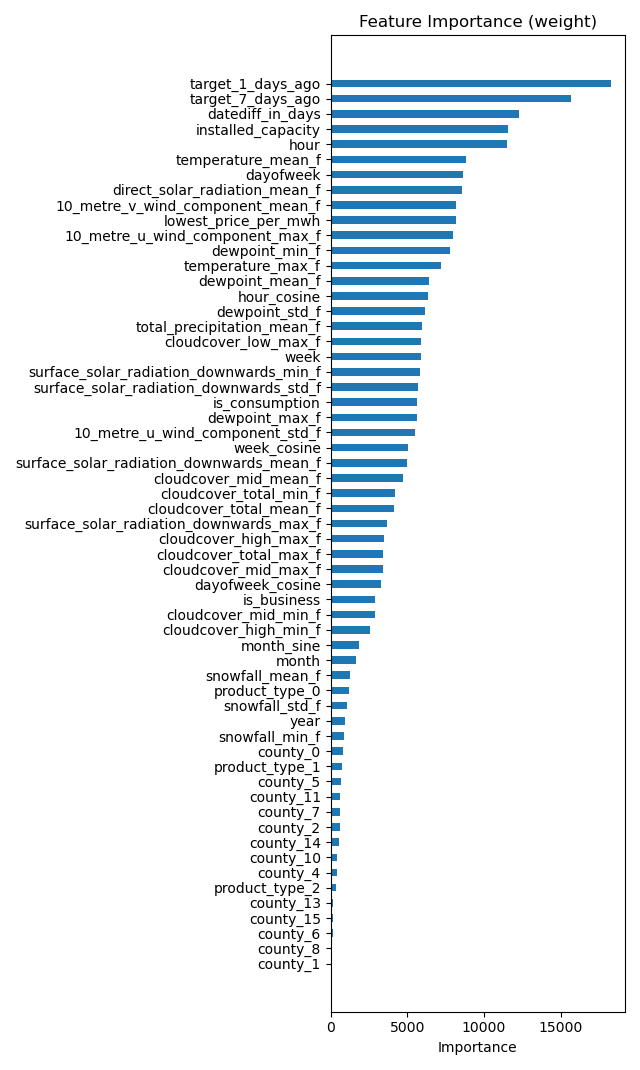

In [35]:
mlflow.artifacts.load_image(artifact_uri=artifact_uri+"/feature_importance_weight.png")